In [1]:
import numpy as np
from lab2_tools import *
from prondict import prondict
from matplotlib import pyplot as plt
import warnings
%matplotlib inline

In [2]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']
phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
phones = list(sorted(phoneHMMs.keys()))
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()


## 4 Concatenating HMMs

Speech is not stationary. We need to model short segments independently by using foundamental units. The foundamental units can not be the entire words, but they can be phonemes. Usually, for each phoneme we model three segments. Every segment can be represented by 13 MFCCs.

In [3]:
def concatHMMs(hmmmodels, namelist):
    concat = hmmmodels[namelist[0]]
    for idx in range(1,len(namelist)):
        concat = concatTwoHMMs(concat, hmmmodels[namelist[idx]])
    return concat


def concatTwoHMMs(hmm1, hmm2):
    hmm_combined = {}
    exit_state1_pi = hmm1['startprob'][-1] #a priori probability of exit state (model 1)
    hmm_combined['startprob'] = np.array(list(hmm1['startprob'][:-1]) + list(hmm2['startprob']*exit_state1_pi)) 
    
    hmm_combined['transmat'] = np.zeros( (len(hmm_combined['startprob']), len(hmm_combined['startprob'])) )#(k+1)x(k+1)
    transmat1_shape = hmm1['transmat'].shape
    hmm_combined['transmat'][:transmat1_shape[0], :transmat1_shape[1]-1] = hmm1['transmat'][:,:-1]#Do not include exit_state1_A
    exit_state1_A = hmm1['transmat'][:-1,-1] #transition probability from state i to exit state (model 1)
    products_p = np.array([exit_state1_A * i for i in hmm2['startprob']]).T #Colored part of the 'A-concat' matrix in the paper
                                                                            #concatenating_hmms, page 4
    hmm_combined['transmat'][:transmat1_shape[0]-1, transmat1_shape[1]-1:] = products_p 
    hmm_combined['transmat'][transmat1_shape[0]-1:, transmat1_shape[1]-1:] = hmm2['transmat']
    hmm_combined['means'] = np.concatenate((hmm1['means'], hmm2['means']))
    hmm_combined['covars'] = np.concatenate((hmm1['covars'], hmm2['covars']))
    return hmm_combined


In [4]:
twoHMMs = concatTwoHMMs(phoneHMMs['sil'], phoneHMMs['ow'])
wordHMMs = {}
wordHMMs['o'] = concatHMMs(phoneHMMs, ['sil', 'ow', 'sil'])

## 5 HMM Likelihood and Recognition


#### 5.1 Gaussian emission probabilities

In [5]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars']) 
if np.allclose(obsloglik, example["obsloglik"]):
    print("THE TWO ARRAYS ARE THE SAME ", u'\u2713')

THE TWO ARRAYS ARE THE SAME  ✓


Text(0, 0.5, 'States')

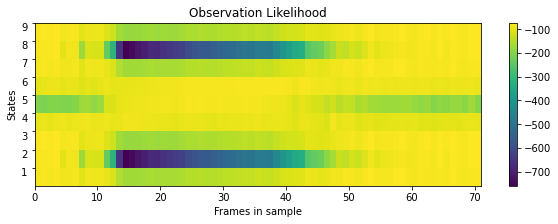

In [6]:
plt.rcParams['figure.figsize'] = [10, 3]
plt.title("Observation Likelihood")
plt.pcolormesh(obsloglik.T)
plt.colorbar()
plt.yticks(range(1,10), verticalalignment='top')
plt.xlabel('Frames in sample')
plt.ylabel('States')

In the figure above we are plotting the probablities of each state, given a time instance in the utterance of the sound.
The word 'o' is made of 3 phoneme (each of them modeled with 3 states), one of them corrisponds to O(ow), and the other two are 'sil' (silence) and they are placed at the start and end of the utterence. In other words, the first and last frames of the sample are mostly silent and the middle frames correspond to the word 'o'

From the color bar, blue indicates that the pobability that the model is in that state, given the corresponding time frame, is low.  Yellow indicates a higher probability. Thus, as expected, towards the start and the end of the utterence (time frames) we have a higher probability in states 1,2,3 and 7,8,9 (silence 'sil'), and blue in states 4,5,6 (o wird 'ow'). On the other hand, we have a higher probability in states 4,5,6 in the middle of the utterence, between time frames 15 and 45, which correspond to the word 'o'.

#### 5.2 Forward Algorithm

In [7]:
def forward(log_emlik, log_startprob, log_transmat):
    alphas = np.zeros((log_emlik.shape))
    alphas[0, :] = log_emlik[0, :] + log_startprob[:-1]#alpha zeros, first row of the matrix at time step 1.
    
    for n in range(1, log_emlik.shape[0]):
        
        for state in range(log_emlik.shape[1]):
            alphas[n, state] = logsumexp(alphas[n-1, :] + log_transmat[:-1, state], axis=0) + log_emlik[n, state]
    
    return alphas
    

In [8]:
alphas = forward(obsloglik, np.log(wordHMMs['o']['startprob']), np.log(wordHMMs['o']['transmat']))
if np.allclose(alphas, example['logalpha']):
    print("THE TWO ARRAYS ARE THE SAME ", u'\u2713')

THE TWO ARRAYS ARE THE SAME  ✓


<ipython-input-8-3d342c952f57>:1: RuntimeWarning: divide by zero encountered in log
  alphas = forward(obsloglik, np.log(wordHMMs['o']['startprob']), np.log(wordHMMs['o']['transmat']))


Text(0, 0.5, 'States')

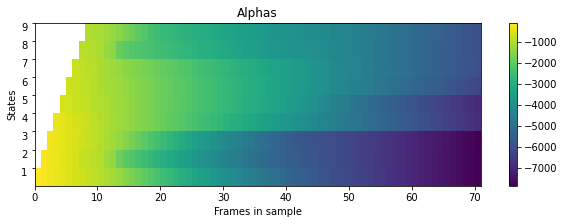

In [9]:
plt.rcParams['figure.figsize'] = [10, 3]
plt.title("Alphas")
plt.pcolormesh(alphas.T)
plt.colorbar()
plt.yticks(range(1,10), verticalalignment='top')
plt.xlabel('Frames in sample')
plt.ylabel('States')

alpha represent the probabilty of observing a given sequence o_1,o_2,...,o_n and ending up in state j. 

From the observation likelihood calculated in the previous section, we know that the utterance 'ow' lies in the frames 15-45, right in the middle of two silence phones. This alpha pass shows a similar behaviour: between time step 15-45 we get higher values in states 4,5,6, whereas for time step 0 to 15 and 50 to 71 we get higher probabilities in states 1,2,3 and 7,8,9 respectivly. Notice that as the frames move to end, the probabilities of states tend to increase as we move from state 1 to 9.

Since alpha is the probabilty of observing a given sequence and eding up in a particular state, the probabilty of obeserving the entire sequence regardless of where we might end up is obtained by marginalizing out the 'state variable', once the sequence of observations is completeed.

In [10]:
if np.allclose(alphas[-1,-1] , example["loglik"]):
    print("the two likelihoods are the same ", u'\u2713')

the two likelihoods are the same  ✓


In [11]:
def final_logLikelihood(phoneHMMs, max_plot = False):
#create a dictionary with the 11 models and their corrispondent parameters
    wordHMMs_all = {}
    matrix_final_alphas = np.zeros((len(prondict.keys()), data.shape[0]))

    for utterence in range(len(data)):
        i = 0
        for digit in prondict.keys():

            wordHMMs_all[digit] = concatHMMs(phoneHMMs, ['sil'] + prondict[str(digit)] + ['sil'])
            obsloglik = log_multivariate_normal_density_diag(data[utterence]['lmfcc'], wordHMMs_all[str(digit)]['means'], 
                                                             wordHMMs_all[str(digit)]['covars'])
            alphas = forward(obsloglik, np.log(wordHMMs_all[str(digit)]['startprob']), np.log(wordHMMs_all[str(digit)]['transmat']))
            sequence_logLikelihood = alphas[-1,-1]
            matrix_final_alphas[i][utterence] = sequence_logLikelihood
            i+=1
            
    if max_plot:
        matrix_final_alphas_max = np.copy(matrix_final_alphas)
        max_alpha = (matrix_final_alphas_max == matrix_final_alphas_max.max(axis = 0,keepdims = 1))
        return max_alpha, wordHMMs_all
    else:
        return matrix_final_alphas, wordHMMs_all

In [21]:
%%time
warnings.filterwarnings('ignore')
matrix_final_alphas, wordHMMs_all = final_logLikelihood(phoneHMMs, max_plot = False)#phoneHMMs

Wall time: 17.6 s


Wall time: 15.6 s


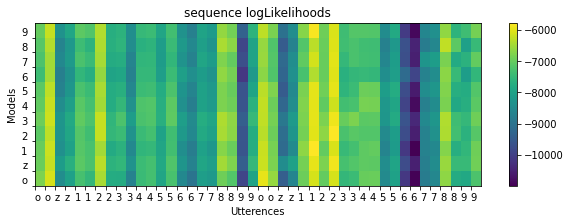

In [12]:
all_words = [x for x in wordHMMs_all]
all_utterance = [x['digit'] for x in data]   

plt.rcParams['figure.figsize'] = [10, 3]
plt.title("sequence logLikelihoods")
plt.pcolormesh(matrix_final_alphas)
plt.colorbar()
plt.yticks(range(1,10), verticalalignment='top')
plt.xlabel('Utterences')
plt.ylabel('Models')
plt.yticks(range(len(all_words)), all_words, verticalalignment = 'bottom')
_ = plt.xticks(range(len(all_utterance)), all_utterance, horizontalalignment = 'left')

Accuracy : 97.72727272727273


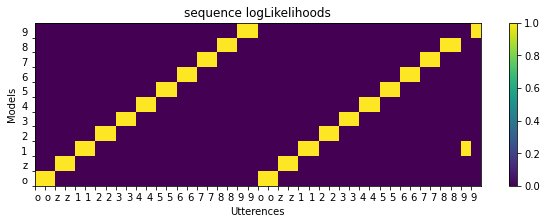

In [13]:
matrix_final_alphas, wordHMMs_all = final_logLikelihood(phoneHMMs_all, max_plot = True)#phoneHMMs
all_words = [x for x in wordHMMs_all]
all_utterance = [x['digit'] for x in data]   

plt.rcParams['figure.figsize'] = [10, 3]
plt.title("sequence logLikelihoods")
plt.pcolormesh(matrix_final_alphas)
plt.colorbar()
plt.yticks(range(1,10), verticalalignment='top')
plt.xlabel('Utterences')
plt.ylabel('Models')
plt.yticks(range(len(all_words)), all_words, verticalalignment = 'bottom')
_ = plt.xticks(range(len(all_utterance)), all_utterance, horizontalalignment = 'left')
match = 0
for i in range(len(all_words)):
    for j in range(len(all_utterance)):
        if(matrix_final_alphas[i,j] == True and all_words[i] == all_utterance[j]):
            match += 1
print("Accuracy :", 100*float(match)/matrix_final_alphas.shape[1])

#### Viterbi algorithm

In [14]:
def viterbi(log_emlik, log_startprob, log_transmat, forceFinalState=True):
    """Viterbi path.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j
        forceFinalState: if True, start backtracking from the final state in
                  the model, instead of the best state at the last time step

    Output:
        viterbi_loglik: log likelihood of the best path
        viterbi_path: best path
    """
    
    N = log_emlik.shape[0]
    M = log_emlik.shape[1]
    
    viterbi_path = [None]*N
    viterbi_loglik = 0
    V = np.zeros((N,M))
    B = np.zeros((N,M))
    
    for obs in range(N):
        for state in range(M):
            if obs == 0:
                V[0, state] = log_startprob[state] + log_emlik[0, state]
            else:
                V[obs, state] = np.max(V[obs-1, :] + log_transmat[:, state]) + log_emlik[obs, state]
                B[obs, state] = np.argmax(V[obs-1, :] + log_transmat[:, state])
                
    viterbi_path[-1] = np.argmax(B[-1, :])
    viterbi_loglik = V[-1, viterbi_path[-1]]
    
    for obs in range(2, N+1):
        st = viterbi_path[-obs+1]
        viterbi_path[-obs] = B[-obs+1, int(st)]
        
    return viterbi_loglik, viterbi_path

In [15]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  
vloglik, vpath = viterbi(obsloglik, np.log(wordHMMs['o']['startprob'][:-1]), np.log(wordHMMs['o']['transmat'][:-1,:-1]))
if np.allclose(vloglik, example['vloglik']):
    print("vloglik ", u'\u2713')
if np.allclose(vpath, example['vpath']):
    print("vpath ", u'\u2713')

vloglik  ✓
vpath  ✓


[1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9]


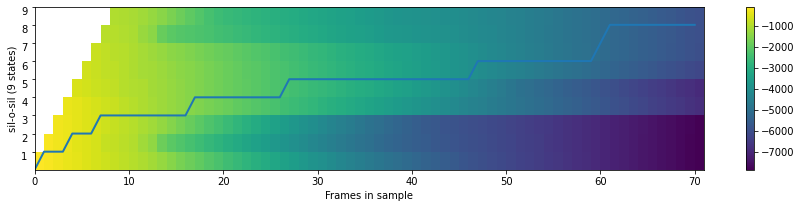

In [16]:
alphas = forward(obsloglik, np.log(wordHMMs['o']['startprob']), np.log(wordHMMs['o']['transmat']))
alpha_max = np.copy(alphas.T)
alpha_max = (alpha_max == alpha_max.max(axis = 0,keepdims = 1))
_ = plt.figure(figsize=(15,3))
_ = plt.pcolormesh(np.ma.masked_array(alphas.T))
_ = plt.plot(vpath, linewidth = 2)
_ = plt.colorbar()
_ = plt.yticks(range(1,10), verticalalignment='top')
_ = plt.xlabel('Frames in sample')
_ = plt.ylabel('sil-o-sil (9 states)')
print([x + 1 for x in vpath])

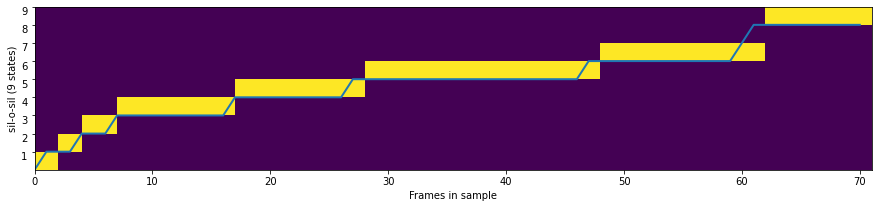

In [17]:
alpha_max = np.copy(alphas.T)
alpha_max = (alpha_max == alpha_max.max(axis = 0,keepdims = 1))
_ = plt.figure(figsize=(15,3))
_ = plt.pcolormesh(np.ma.masked_array(alpha_max))
_ = plt.plot(vpath, linewidth = 2)
_ = plt.yticks(range(1,10), verticalalignment='top')
_ = plt.xlabel('Frames in sample')
_ = plt.ylabel('sil-o-sil (9 states)')

In [18]:
%%time
warnings.filterwarnings('ignore')
performance = np.zeros((44,11))
#for words in wordHMMs: print(words, end = "\t")
#print()
no_utterance = 0
for utterance in data:
    no_word = 0 
    for word in wordHMMs_all:
        obsloglik = log_multivariate_normal_density_diag(utterance['lmfcc'], wordHMMs_all[word]['means'], wordHMMs_all[word]['covars'])  
        log_startprob = np.log(wordHMMs_all[word]['startprob'][:-1])
        log_transmat = np.log(wordHMMs_all[word]['transmat'][:-1,:-1])
        vloglik, vpath = viterbi(obsloglik, log_startprob, log_transmat)
        performance[no_utterance, no_word] = vloglik
        #print(int(hmm_loglik), end = "\t")
        #print(no_utterance,no_word ,end = '\t')
        no_word += 1
    #print()
    no_utterance += 1
#uncomment prints to display as tables with integer values

Wall time: 7.08 s


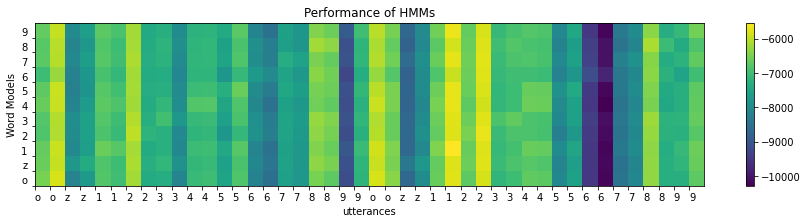

In [19]:
all_words = []
for x in wordHMMs_all: all_words.append(x)
all_utterance = []   
for x in data: all_utterance.append(x['digit'])
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(111).set_title("Performance of HMMs")
_ = plt.pcolormesh(performance.T)
_ = plt.colorbar()
_ = plt.ylabel('Word Models')
_ = plt.xlabel('utterances')
_ = plt.yticks(range(len(all_words)), all_words, verticalalignment = 'bottom')
_ = plt.xticks(range(len(all_utterance)), all_utterance, horizontalalignment = 'left')

Accuracy : 100.0


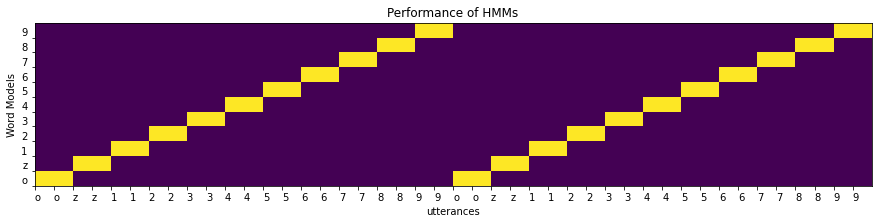

In [20]:
performance_max = np.copy(performance.T)
predictions_viterbi = (performance_max == performance_max.max(axis = 0,keepdims = 1))
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(111).set_title("Performance of HMMs")
_ = plt.pcolormesh(predictions_viterbi)
_ = plt.ylabel('Word Models')
_ = plt.xlabel('utterances')
_ = plt.yticks(range(len(all_words)), all_words, verticalalignment = 'bottom')
_ = plt.xticks(range(len(all_utterance)), all_utterance, horizontalalignment = 'left')
match = 0
for i in range(len(all_words)):
    for j in range(len(all_utterance)):
        if(predictions_viterbi[i,j] == True and all_words[i] == all_utterance[j]):
            match += 1
print("Accuracy :", 100*float(match)/predictions_viterbi.shape[1])